In [4]:
!pip install geotext
from geotext import GeoText
import pandas as pd
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
!pip install spacy
!python -m spacy download en_core_web_sm

  Using cached spacy-3.7.5-cp39-cp39-win_amd64.whl.metadata (27 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached murmurhash-1.0.10-cp39-cp39-win_amd64.whl.metadata (2.0 kB)
  Using cached cymem-2.0.8-cp39-cp39-win_amd64.whl.metadata (8.6 kB)
  Using cached preshed-3.0.9-cp39-cp39-win_amd64.whl.metadata (2.2 kB)
  Using cached thinc-8.2.4-cp39-cp39-win_amd64.whl.metadata (15 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached srsly-2.4.8-cp39-cp39-win_amd64.whl.metadata (20 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.4.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached typer-0.12.3-py3-none-any.whl.metadata (15 kB)
  Using cached langcodes-3.4.0-py3-none-any.whl.metadata (29 kB)
  Using cached language_data-1.2.0-py3-none-any.whl.metadata (4.3 kB)


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\users\\dmittal\\anaconda3\\lib\\site-packages\\numpy-1.23.5.dist-info\\METADATA'

C:\Users\dmittal\Anaconda3\python.exe: No module named spacy


In [5]:

df = pd.read_csv('UK_data.csv')

In [8]:
# function to get unique values
def unique(list1):
 
    # initialize a null list
    unique_list = []
 
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list
             

In [ ]:
city_groups=[]

for i in range(df.shape[0]):
    if(pd.isnull(df.text[i])):
        print('Nan value')
    else:
# Extract cities using GeoText
        text=df.text[i]
        places = GeoText(text)
        cities_geotext = unique(places.cities)

# Use spaCy to filter the results
        doc = nlp(text)
        cities_spacy = unique([ent.text for ent in doc.ents if ent.label_ == 'GPE'])

# Combine results and filter out incorrect matches
        cities = list(set(cities_geotext) & set(cities_spacy))

        
        city_groups.append(cities)

In [76]:
# Add edges to the graph


G = nx.Graph()

for group in city_groups:
    # Create edges between all pairs of cities in the same group
    for i in range(len(group)):
        for j in range(i + 1, len(group)):
            G.add_edge(group[i], group[j])



#define minimum degree
min_degree=50

nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree <=min_degree]
G.remove_nodes_from(nodes_to_remove)

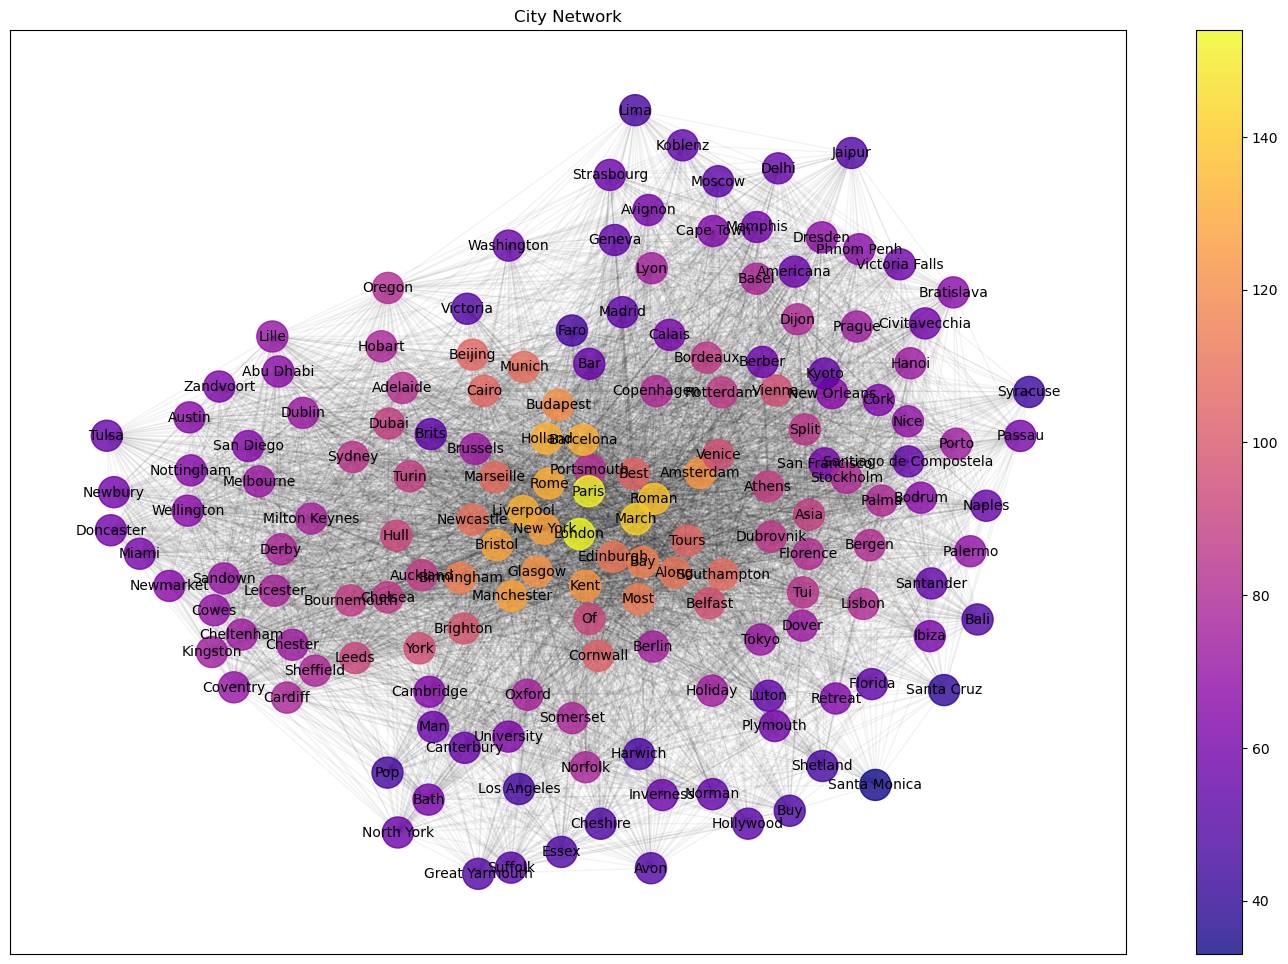

In [79]:
# Draw the graph
plt.figure(figsize=(18, 12))

# Use a spring layout for better spacing
pos = nx.spring_layout(G, k=0.3, iterations=50)

# Draw the nodes with degree-based coloring
degrees = dict(G.degree())
node_color = [degrees[node] for node in G.nodes()]
nodes = nx.draw_networkx_nodes(G, pos, node_size=500, cmap=plt.cm.plasma, node_color=node_color, alpha=0.8)
nodes.set_norm(plt.Normalize(vmin=min(node_color), vmax=max(node_color)))

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.05)

# Draw labels with smaller font size
nx.draw_networkx_labels(G, pos, font_size=10)

# Add color bar
plt.colorbar(nodes)

plt.title('City Network')
plt.show()

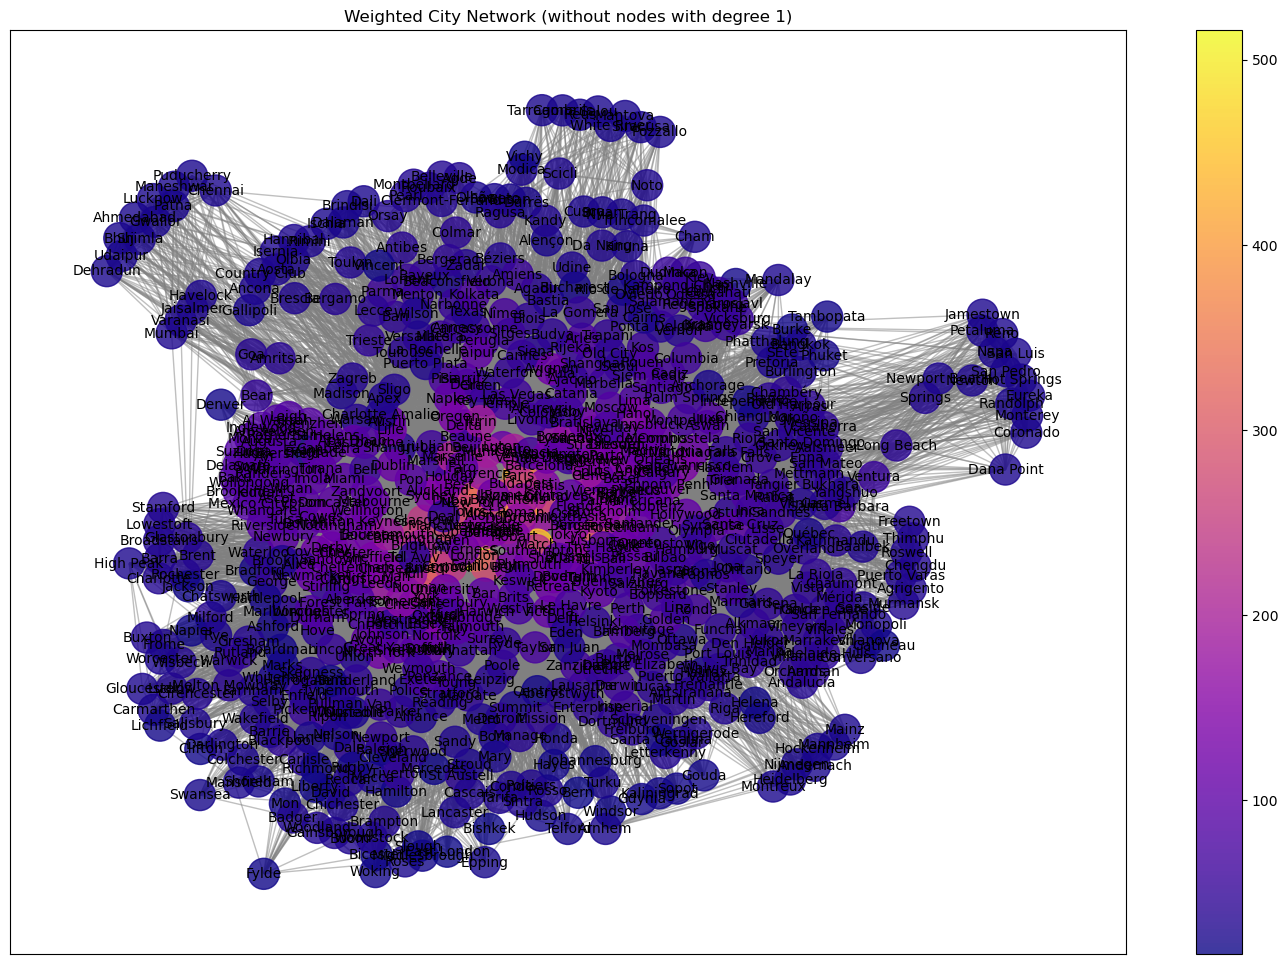

In [69]:

edge_weights = defaultdict(int)

# Count the occurrences of each pair of cities in the same group
for group in city_groups:
    for i in range(len(group)):
        for j in range(i + 1, len(group)):
            edge_weights[(group[i], group[j])] += 1
            edge_weights[(group[j], group[i])] += 1  # Since the graph is undirected

# Create a graph and add weighted edges
G = nx.Graph()

for (city1, city2), weight in edge_weights.items():
    G.add_edge(city1, city2, weight=weight)

# Remove nodes with degree 1
nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree <min_degree]
G.remove_nodes_from(nodes_to_remove)

# Draw the graph with a larger canvas and adjusted node size
plt.figure(figsize=(18, 12))

# Use a spring layout for better spacing
pos = nx.spring_layout(G, k=0.3, iterations=50)

# Draw the nodes with degree-based coloring
degrees = dict(G.degree())
node_color = [degrees[node] for node in G.nodes()]
nodes = nx.draw_networkx_nodes(G, pos, node_size=500, cmap=plt.cm.plasma, node_color=node_color, alpha=0.8)
nodes.set_norm(plt.Normalize(vmin=min(node_color), vmax=max(node_color)))

# Draw edges with width proportional to weight
edges = nx.draw_networkx_edges(
    G, pos, alpha=0.5, edge_color='gray', 
    width=[G[u][v]['weight'] for u, v in G.edges()]
)

# Draw labels with smaller font size
nx.draw_networkx_labels(G, pos, font_size=10)

# Add color bar
plt.colorbar(nodes)

plt.title('Weighted City Network ')
plt.show()